In [35]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import torch
import torch.nn as nn
import numpy as np
import time
import gc
import pandas as pd
from train_helper import train_fn, valid_fn
from config import TrainConfig
from utils import get_logger, get_scheduler, load_pkl, weight_init, save_pkl
from dltime.data.ts_datasets import Soil_Dataset
from dltime.models.inception_atten import TSInceptionSelfAttnEncoderClassifier
from dltime.models.conv_atten import TSTransformerEncoderConvClassifier
from dltime.models.InceptionTime import InceptionTime
from transformers import AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from data_process import handle_dataset_3dims, plot_time
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

/home/shizhaoshu/.conda/envs/torch111/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CFG = TrainConfig()

## zwy

In [37]:
# data process
data_for_train = ['sky2']
train_data = []
for data_name in data_for_train:
    train_data.extend(load_pkl(f'./pickle_data/{data_name}_train.pkl'))

train_x, train_label = handle_dataset_3dims(train_data, mode="all")
train_x = np.swapaxes(train_x, 2, 1)
print('Train data size:', train_x.shape, train_label.shape)

train_dataset = Soil_Dataset(train_x, train_label, normalize=None, channel_first=True)
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=False)

Train data size: (1304, 48, 5) (1304,)


In [38]:
train_data[1100]

{'data_x': array([-0.0035038 , -0.00333595, -0.00341606, -0.00328636, -0.00320625,
        -0.00335693, -0.00333977, -0.00331306, -0.00335693, -0.00340652,
        -0.00339127, -0.00324059, -0.00329208, -0.00358391, -0.00340462,
        -0.00333977, -0.00346184, -0.00322151, -0.00307274, -0.00362015,
        -0.00365257, -0.00471497, -0.0010891 , -0.00515366, -0.00270844,
        -0.00228119, -0.00419235, -0.00447655, -0.00300598, -0.00284004,
        -0.00357437, -0.00314713, -0.00328445, -0.00377846, -0.00328636,
        -0.00336266, -0.00367165, -0.00347137, -0.0033989 , -0.00326729,
        -0.00365829, -0.00350189, -0.00337219, -0.00334549, -0.00352287,
        -0.00325775, -0.00331688, -0.00330162]),
 'data_y': array([-0.02047157, -0.02040672, -0.02055931, -0.0203495 , -0.02033806,
        -0.02038956, -0.02053642, -0.02059174, -0.02052879, -0.02048492,
        -0.02033424, -0.02038193, -0.02037811, -0.02037621, -0.02043152,
        -0.02025604, -0.02034187, -0.0204258 , -0.02075

In [45]:
train_3_idx = [idx for idx, item in enumerate(train_data) if 'dig' in item['file_name'] and '3.0' in item['file_name']]

In [52]:
train_3_idx

[805,
 806,
 807,
 808,
 809,
 810,
 811,
 812,
 813,
 814,
 815,
 816,
 817,
 818,
 819,
 820,
 821,
 822,
 823,
 824,
 825,
 826,
 827,
 828,
 829,
 830,
 831,
 832,
 833,
 834,
 835,
 836,
 837,
 838,
 839,
 840,
 841,
 842,
 843,
 844,
 845,
 846,
 871,
 872,
 873,
 874,
 875,
 876,
 877,
 878,
 879,
 880,
 881,
 882,
 883,
 884,
 885,
 886,
 887,
 888,
 889,
 890,
 891,
 892,
 893,
 894,
 895,
 896,
 897,
 898,
 899,
 900,
 901,
 902,
 903,
 904,
 905,
 906,
 907,
 908,
 909,
 910,
 911,
 912,
 913]

dig_3.0_B.csv


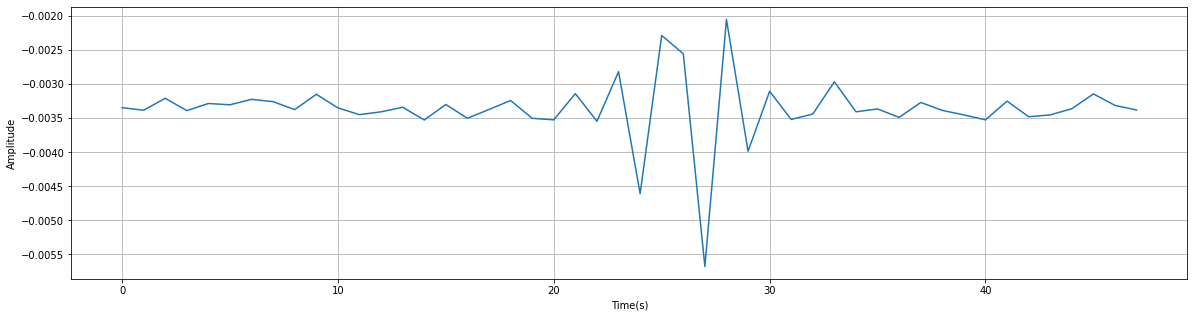

In [55]:
print(train_data[909]['file_name'])
plot_time(train_data[909]['data_x'])

In [36]:
train_data[1100]['file_name']

'walk_3.0_A.csv'

In [5]:
# model = TSInceptionSelfAttnEncoderClassifier(
#         feat_dim=5, 
#         max_len=64, 
#         d_model=512, 
#         num_heads=4,
#         num_layers=4,
#         dim_feedforward=None,
#         num_classes=3)

# model.load_state_dict(torch.load('./outputs/zwy_2022-05-30 15.11.pth', map_location='cpu'))
model = InceptionTime(c_in=5, c_out=3)
model.load_state_dict(torch.load('./outputs/zwy_2022-06-01 00.58.pth', map_location='cpu'))

<All keys matched successfully>

In [6]:
# 预测所有样本
model.eval()
preds = []
for step, item in enumerate(train_loader):
    for k, v in item.items():
        item[k] = v.cpu()

    labels = item['label']
    batch_size = labels.size(0)
    with torch.no_grad():
        y_preds = model(item['input'])

    preds.append(y_preds.cpu().numpy())

predictions = np.concatenate(preds)

In [7]:
# 统计挖掘的误分情况
pred_labels = predictions.argmax(axis=-1)
print(pred_labels)

true0_idx = []
false0_idx = []
for idx, (pred, label) in enumerate(list(zip(pred_labels.tolist(), train_label.tolist()))):
    if pred == label and label == 0:
        true0_idx.append(idx)
    elif pred != label and label == 0:
        false0_idx.append(idx)

print(len(true0_idx), len(false0_idx))


[2 2 2 ... 0 0 0]
1736 74


In [8]:
def _normalize(cams: torch.Tensor) -> torch.Tensor:
    """CAM normalization"""
    cams.sub_(cams.min(-1).values)
    cams.div_(cams.max(-1).values)

    return cams

In [9]:
def data_maxminilize(item):
    new_item = {'data_x': item['data_x'] - np.mean(item['data_x']), \
        'data_y': item['data_y'] - np.mean(item['data_y']), \
        'data_z': item['data_z'] - np.mean(item['data_z'])}
    max_ = max(np.max(new_item['data_x']), np.max(new_item['data_y']), np.max(new_item['data_z']))
    min_ = min(np.min(new_item['data_x']), np.min(new_item['data_y']), np.min(new_item['data_z']))
    for k, v in new_item.items():
        new_item[k] = (v - min_) / (max_ - min_)
    return new_item

In [10]:
label0_idx = [idx for idx, label in enumerate(train_label) if label == 0]
label1_idx = [idx for idx, label in enumerate(train_label) if label == 1]
label2_idx = [idx for idx, label in enumerate(train_label) if label == 2]

In [25]:
idx_wrong = [idx for idx, label in enumerate(train_label) if label != pred_labels[idx]]

In [26]:
idx_wrong

[70,
 78,
 95,
 97,
 125,
 127,
 142,
 144,
 200,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 330,
 331,
 334,
 336,
 338,
 340,
 341,
 342,
 344,
 345,
 346,
 347,
 349,
 350,
 351,
 352,
 371,
 453,
 454,
 466,
 482,
 488,
 492,
 496,
 516,
 530,
 539,
 567,
 575,
 576,
 580,
 581,
 589,
 593,
 596,
 626,
 630,
 631,
 634,
 636,
 639,
 653,
 663,
 664,
 667,
 670,
 671,
 673,
 678,
 682,
 683,
 748,
 785,
 1017,
 1018,
 1050,
 1067,
 1071,
 1074,
 1093,
 1114,
 1124,
 1131,
 1133,
 1139,
 1143,
 1148,
 1149,
 1153,
 1164,
 1165,
 1168,
 1171,
 1172,
 1173,
 1174,
 1175,
 1181,
 1202,
 1207,
 1212,
 1218,
 1221,
 1224,
 1225,
 1227,
 1233,
 1234,
 1239,
 1242,
 1244,
 1245,
 1246,
 1248,
 1250,
 1253,
 1254,
 1258,
 1261,
 1263,
 1267,
 1270,
 1283,
 1294,
 1358,
 1366,
 1375,
 1377,
 1384,
 1408,
 1416,
 1421,
 1438,
 1457,
 1479,
 1641,
 1672,
 1680,
 1681,
 1687,
 1707,
 1753,
 1787,
 1842,
 1851,
 1858,
 1860,
 1864,
 1883,
 1905,
 1911,
 1922,
 1978,
 1981,

In [11]:
for n, p in model.named_parameters():
    print(n)

inceptionblock1.incepmodules.0.bottleneck.conv1d.weight
inceptionblock1.incepmodules.0.convs.0.conv1d.weight
inceptionblock1.incepmodules.0.convs.1.conv1d.weight
inceptionblock1.incepmodules.0.convs.2.conv1d.weight
inceptionblock1.incepmodules.0.maxconvpool.1.conv1d.weight
inceptionblock1.incepmodules.0.bn.weight
inceptionblock1.incepmodules.0.bn.bias
inceptionblock1.incepmodules.1.bottleneck.conv1d.weight
inceptionblock1.incepmodules.1.convs.0.conv1d.weight
inceptionblock1.incepmodules.1.convs.1.conv1d.weight
inceptionblock1.incepmodules.1.convs.2.conv1d.weight
inceptionblock1.incepmodules.1.maxconvpool.1.conv1d.weight
inceptionblock1.incepmodules.1.bn.weight
inceptionblock1.incepmodules.1.bn.bias
inceptionblock1.incepmodules.2.bottleneck.conv1d.weight
inceptionblock1.incepmodules.2.convs.0.conv1d.weight
inceptionblock1.incepmodules.2.convs.1.conv1d.weight
inceptionblock1.incepmodules.2.convs.2.conv1d.weight
inceptionblock1.incepmodules.2.maxconvpool.1.conv1d.weight
inceptionblock1.in

In [12]:
grad_block = []	# 存放grad图
feaure_block = []	# 存放特征图

# 获取梯度的函数
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 获取特征层的函数
def farward_hook(module, input, output):
    feaure_block.append(output)

model.inceptionblock2.register_forward_hook(farward_hook)
model.inceptionblock2.register_backward_hook(backward_hook)

/home/shizhaoshu/.conda/envs/torch111/lib/python3.7/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/shizhaoshu/.conda/envs/torch111/lib/python3.7/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/shizhaoshu/.conda/envs/torch111/lib/python3.7/site-packages/torch/nn/mod

torch.Size([1, 3])


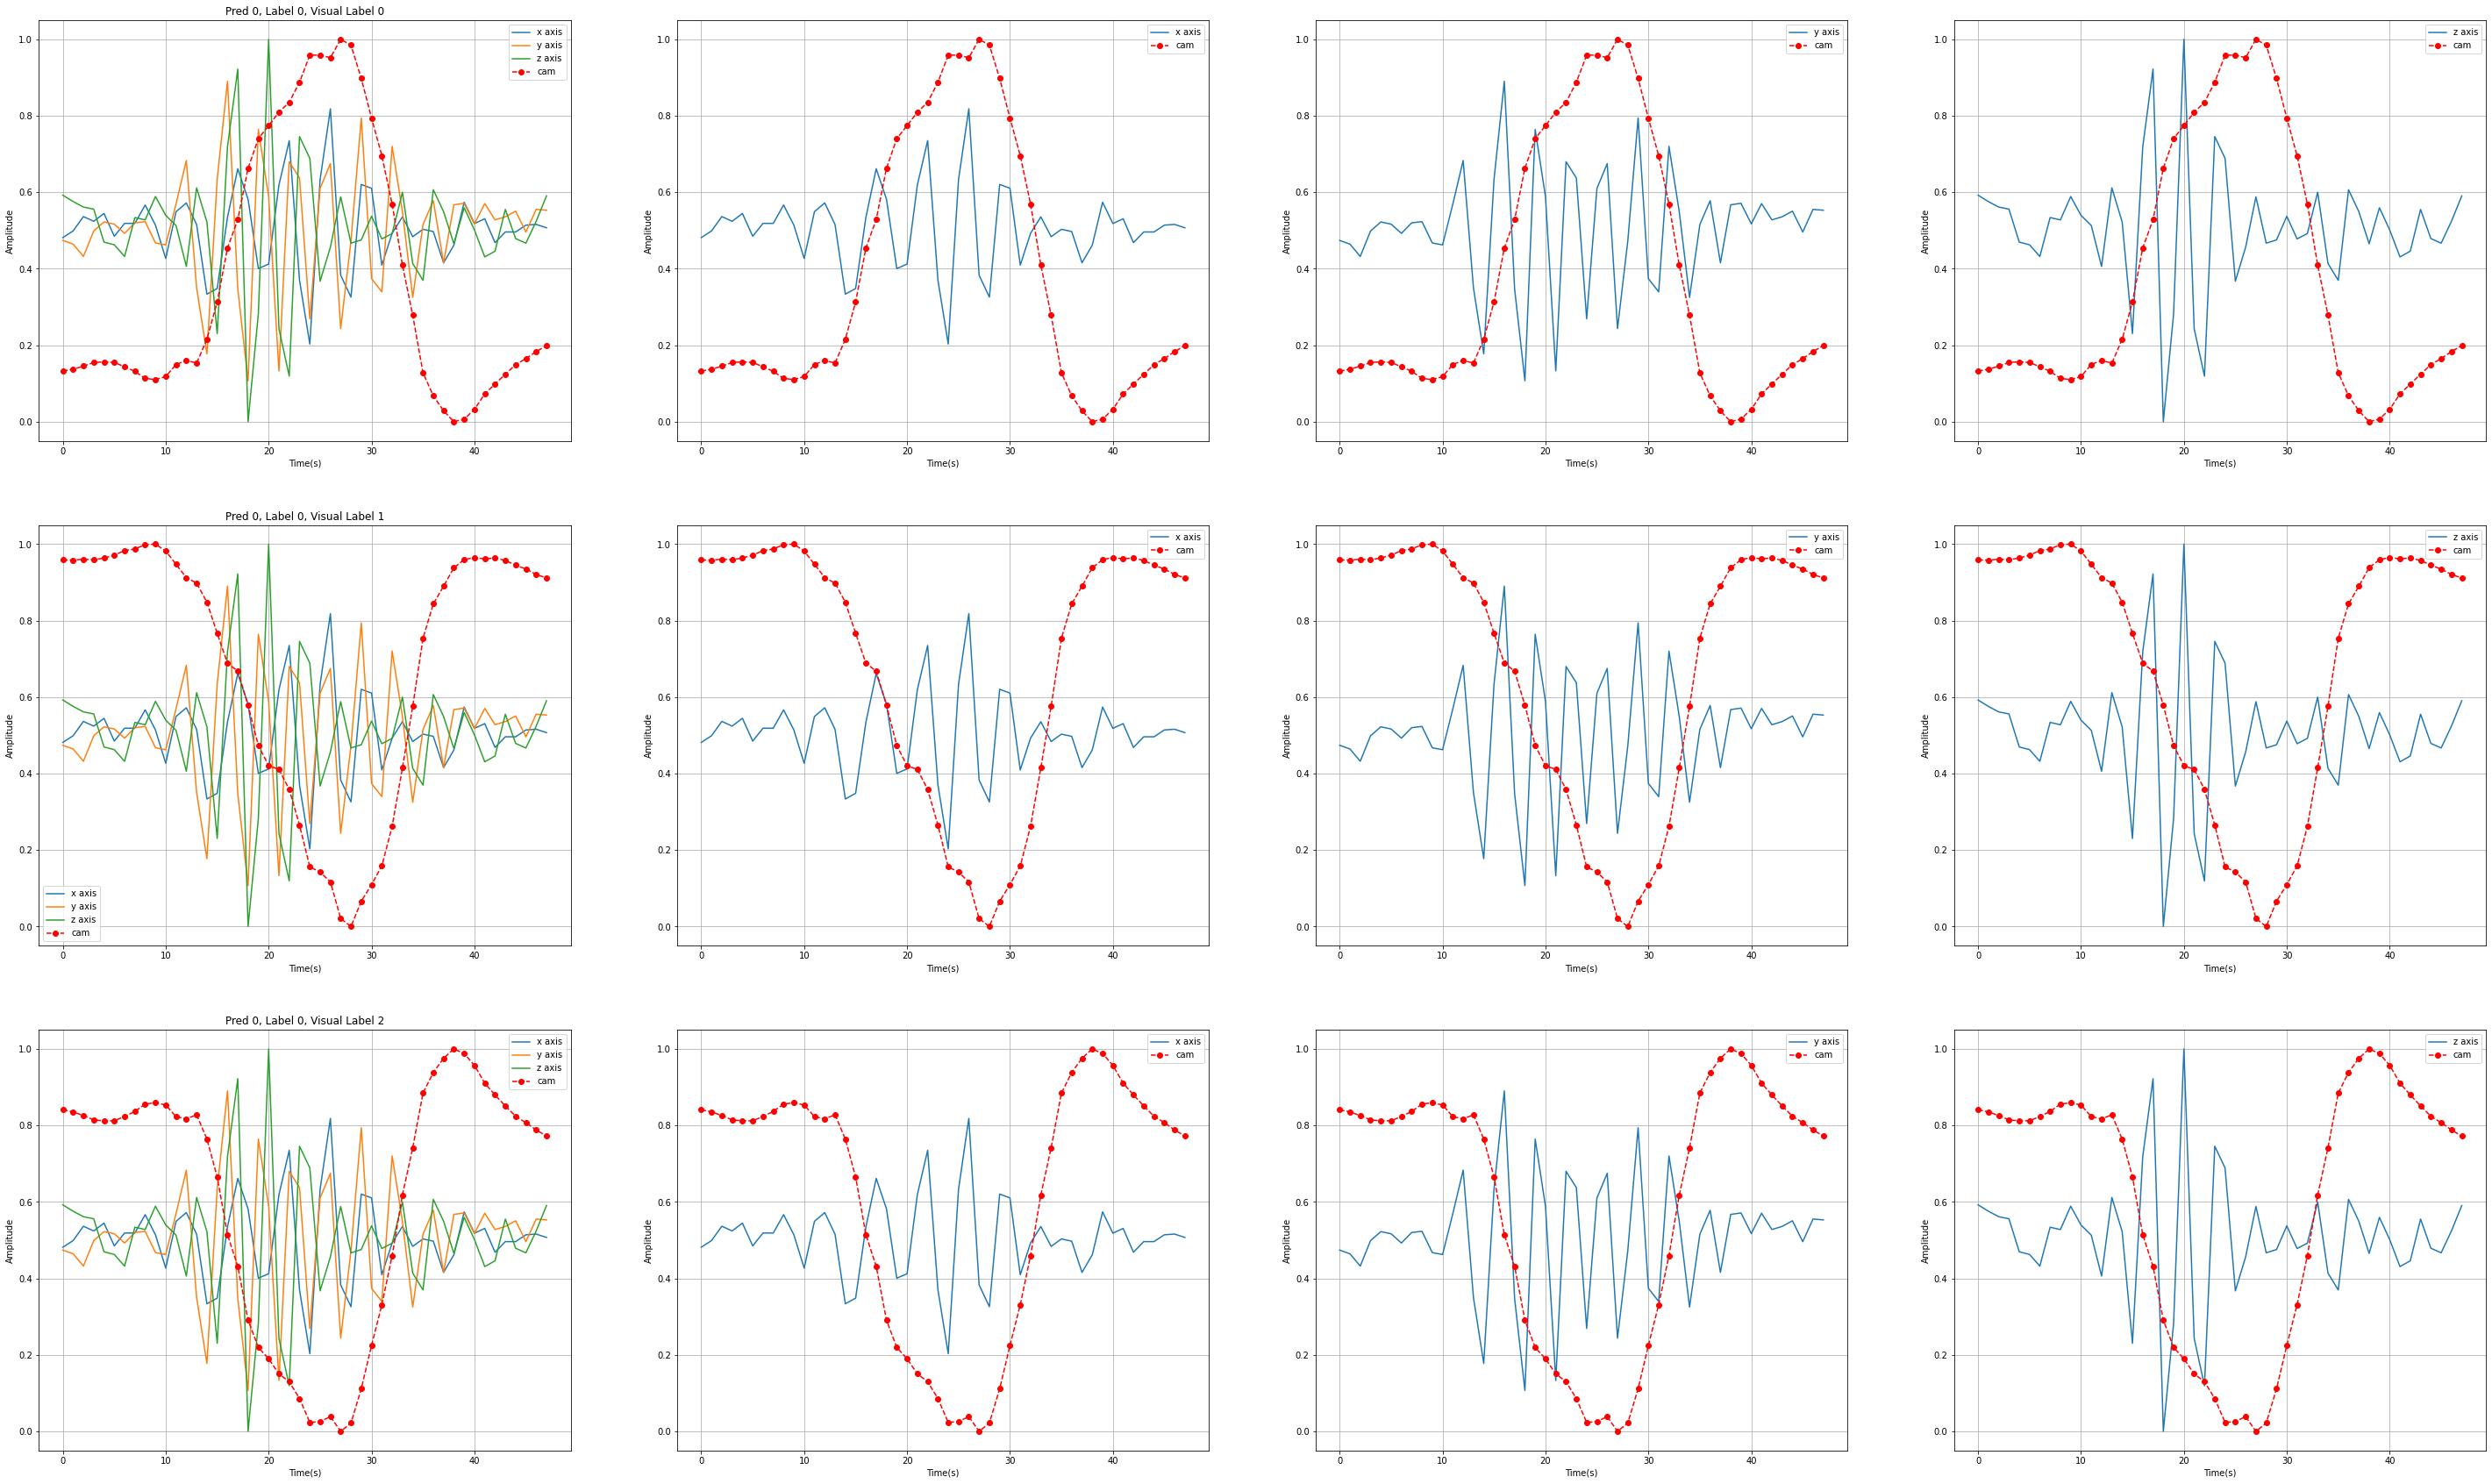

In [34]:
idx = 300
item = data_maxminilize(train_data[idx])
input_tensor = train_dataset[idx]['input'].unsqueeze(0).cpu()

fig = plt.figure(figsize=(50, 30))

model.zero_grad()
output = model(input_tensor)
cls = torch.argmax(output).cpu().numpy()
print(output.size())
class_loss = output[0, 0]	# 取最大类别的值作为loss，这样计算的结果是模型对该类最感兴趣的cam图
class_loss.backward()	# 反向梯度，得到梯度图

# grads
grads_val = F.adaptive_avg_pool1d(grad_block[-1], 1).cpu().data.squeeze() # 取均值, 每个通道的权重
fmap = feaure_block[-1].cpu().data.squeeze()

for i in range(128):
    fmap[i, ...] *= grads_val[i, ...]

cam = _normalize(torch.mean(fmap.squeeze(), dim=0))

plt.subplot(3, 4, 1)
time = np.arange(0, len(item['data_x']))
plt.plot(time, item['data_x'], label='x axis')
plt.plot(time, item['data_y'], label='y axis')
plt.plot(time, item['data_z'], label='z axis')
plt.plot(time, cam, label='cam', c='r', linestyle='--', marker='o')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title(f'Pred {cls}, Label {train_label[idx]}, Visual Label {0}')
plt.legend()
plt.grid()

plt.subplot(3, 4, 2)
plt.plot(time, item['data_x'], label='x axis')
plt.plot(time, cam, label='cam', c='r', linestyle='--', marker='o')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.subplot(3, 4, 3)
plt.plot(time, item['data_y'], label='y axis')
plt.plot(time, cam, label='cam', c='r', linestyle='--', marker='o')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.subplot(3, 4, 4)
plt.plot(time, item['data_z'], label='z axis')
plt.plot(time, cam, label='cam', c='r', linestyle='--', marker='o')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# 标签1 回传的可视化
model.zero_grad()
output = model(input_tensor)
class_loss = output[0, 1]	# 取最大类别的值作为loss，这样计算的结果是模型对该类最感兴趣的cam图
class_loss.backward()	# 反向梯度，得到梯度图

# grads
grads_val = F.adaptive_avg_pool1d(grad_block[-1], 1).cpu().data.squeeze()
fmap = feaure_block[-1].cpu().data.squeeze()

for i in range(128):
    fmap[i, ...] *= grads_val[i, ...]

cam = _normalize(torch.mean(fmap.squeeze(), dim=0))

plt.subplot(3, 4, 5)
plt.plot(time, item['data_x'], label='x axis')
plt.plot(time, item['data_y'], label='y axis')
plt.plot(time, item['data_z'], label='z axis')
plt.plot(time, cam, label='cam', c='r', linestyle='--', marker='o')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title(f'Pred {cls}, Label {train_label[idx]}, Visual Label {1}')
plt.legend()
plt.grid()

plt.subplot(3, 4, 6)
plt.plot(time, item['data_x'], label='x axis')
plt.plot(time, cam, label='cam', c='r', linestyle='--', marker='o')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.subplot(3, 4, 7)
plt.plot(time, item['data_y'], label='y axis')
plt.plot(time, cam, label='cam', c='r', linestyle='--', marker='o')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.subplot(3, 4, 8)
plt.plot(time, item['data_z'], label='z axis')
plt.plot(time, cam, label='cam', c='r', linestyle='--', marker='o')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()


# 标签2 回传的可视化
model.zero_grad()
output = model(input_tensor)
class_loss = output[0, 2]	# 取最大类别的值作为loss，这样计算的结果是模型对该类最感兴趣的cam图
class_loss.backward()	# 反向梯度，得到梯度图

# grads
grads_val = F.adaptive_avg_pool1d(grad_block[-1], 1).cpu().data.squeeze()
fmap = feaure_block[-1].cpu().data.squeeze()

for i in range(128):
    fmap[i, ...] *= grads_val[i, ...]

cam = _normalize(torch.mean(fmap.squeeze(), dim=0))

plt.subplot(3, 4, 9)
plt.plot(time, item['data_x'], label='x axis')
plt.plot(time, item['data_y'], label='y axis')
plt.plot(time, item['data_z'], label='z axis')
plt.plot(time, cam, label='cam', c='r', linestyle='--', marker='o')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title(f'Pred {cls}, Label {train_label[idx]}, Visual Label {2}')
plt.legend()
plt.grid()

plt.subplot(3, 4, 10)
plt.plot(time, item['data_x'], label='x axis')
plt.plot(time, cam, label='cam', c='r', linestyle='--', marker='o')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.subplot(3, 4, 11)
plt.plot(time, item['data_y'], label='y axis')
plt.plot(time, cam, label='cam', c='r', linestyle='--', marker='o')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.subplot(3, 4, 12)
plt.plot(time, item['data_z'], label='z axis')
plt.plot(time, cam, label='cam', c='r', linestyle='--', marker='o')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

fig.savefig(f"cam_results/zwy_incep/sample{idx}_pred{cls}_label{train_label[idx]}.jpg")

In [25]:
weights = model._modules.get('output_layer').weight.data[2,:]    # 获取类别对应的权重
cam = (weights.view(*weights.shape, 1) * feature_map[-1].squeeze(0)).sum(0)

In [26]:
cam

tensor([ -0.3109,  -4.4600,  -7.7097, -10.7226, -10.4509, -10.3709, -10.1030,
         -6.0992,  -3.9256,  -1.4857,  -1.4813,  -1.5088,  -1.5556,  -1.6341,
         -1.6743,  -1.7780,  -1.8187,  -1.8389,  -1.8129,  -1.8190,  -1.8328,
         -1.8522,  -1.8769,  -1.8781,  -1.8779,  -1.8782,  -1.8714,  -1.8798,
         -1.8860,  -1.8711,  -1.8390,  -1.7888,  -1.7760,  -1.7598,  -1.2861,
         -0.8345,  -2.8262,  -6.4337, -10.5799, -10.4199,  -8.6775,  -4.2530,
         -2.4536,  -1.8213,  -1.8619,  -1.9188,  -2.0184,  -0.7632])

In [153]:
cls = torch.argmax(out).item()    # 获取预测类别编码
weights = model._modules.get('output_layer').weight.data[cls,:]    # 获取类别对应的权重
cls

2

In [154]:
cam = (weights.view(*weights.shape, 1) * feature_map[-1].squeeze(0)).sum(0)

In [155]:
def _normalize(cams: torch.Tensor) -> torch.Tensor:
    """CAM normalization"""
    cams.sub_(cams.min(-1).values.unsqueeze(-1))
    cams.div_(cams.max(-1).values.unsqueeze(-1))

    return cams

In [157]:
cam

tensor([0.2237, 0.2936, 0.4886, 0.7308, 0.8698, 1.0000, 0.9020, 0.8356, 0.7292,
        0.2068, 0.0000, 0.0000, 0.0000, 0.0000, 0.1051, 0.8495, 0.7358, 0.7450,
        0.7773, 0.5643, 0.2474, 0.0596, 0.2529, 0.5394, 0.5452, 0.8111, 0.8342,
        0.8991, 0.7621, 0.6251, 0.4595, 0.2754, 0.0528, 0.0299, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0280, 0.0000, 0.0000, 0.0000, 0.0719, 0.0318, 0.0000,
        0.0000, 0.0000, 0.0942])

In [158]:
from data_process import plot_time

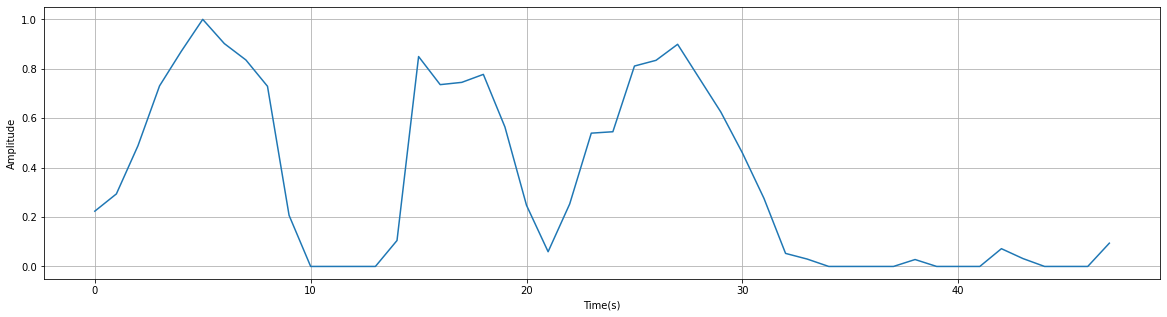

In [159]:
plot_time(cam)

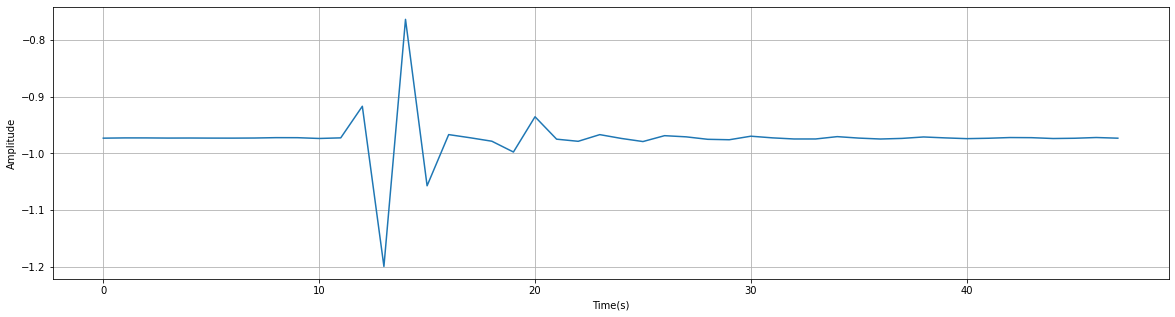

In [160]:
plot_time(train_data[1000]['data_z'])